---
title: Working with pyCATHY and DA with ERT datasets
subtitle: PART3 - plotting the **Archie** transformation results
license: CC-BY-4.0
github: https://github.com/BenjMy/ETH_pyCATHY/
subject: Tutorial
authors:
  - name: Benjamin Mary
    email: benjamin.mary@ica.csic.es
    corresponding: true
    orcid: 0000-0001-7199-2885
    affiliations:
      - ICA-CSIC
date: 2024/04/12
---

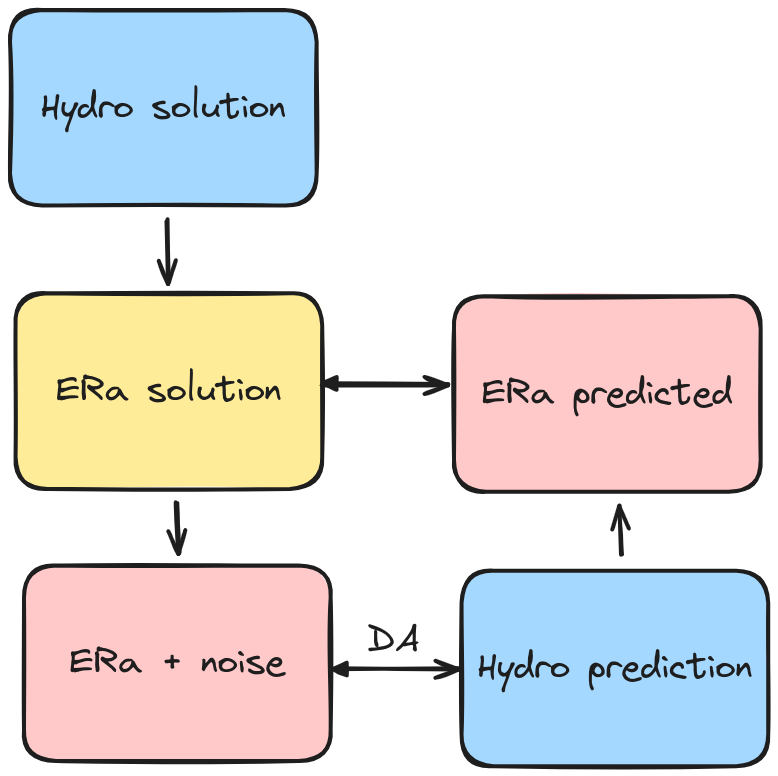

The notebooks describe: 

**Plot outputs**: analysis of the results
   - [Saturation with uncertainties](plot_states)
   - [Parameters convergence](Parm_evol)
   - [Assimilation performance](DA_perf)

In [36]:
import pyCATHY
from pyCATHY import cathy_tools
from pyCATHY.DA.cathy_DA import DA, dictObs_2pd
from pyCATHY.DA.perturbate import perturbate_parm
from pyCATHY.DA import perturbate
from pyCATHY.DA.observations import read_observations, prepare_observations, make_data_cov
from pyCATHY.DA import performance
from pyCATHY.ERT import petro_Archie as Archie
import pyCATHY.meshtools as cathy_meshtools
import pyvista as pv
import pyCATHY.plotters.cathy_plots as cplt 
import os 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# set some default plotting parameters for nicer looking plots
mpl.rcParams.update({"axes.grid":True, 
                     "grid.color":"gray", 
                     "grid.linestyle":'--',
                     'figure.figsize':(6,6)}
                   )
import pandas as pd
import utils

In [18]:
import pygimli as pg 
from pygimli.physics import ert

(plot_results)=
# Analysis of the results

## Reload solution

In [19]:
simu_solution = cathy_tools.CATHY(
                                    dirName='./solution_ERT',
                                    prj_name= 'weill_dataset',
                                    notebook=True,
                                  )
sw_SOL, sw_SOL_times = simu_solution.read_outputs('sw')
psi_SOL = simu_solution.read_outputs('psi')

rootMap, rootMap_hd = simu_solution.read_inputs('root_map')

soil_SPP_SOL, soil_FP_SOL = simu_solution.read_inputs('soil',
                                                         MAXVEG=int(np.max(rootMap)),
                                                    )
PERMX_SOL = soil_SPP_SOL['PERMX'].unique()[0]
POROS_SOL = soil_SPP_SOL['POROS'].unique()[0]

🏁 Initiate CATHY object

### Plot saturation 2D solution 

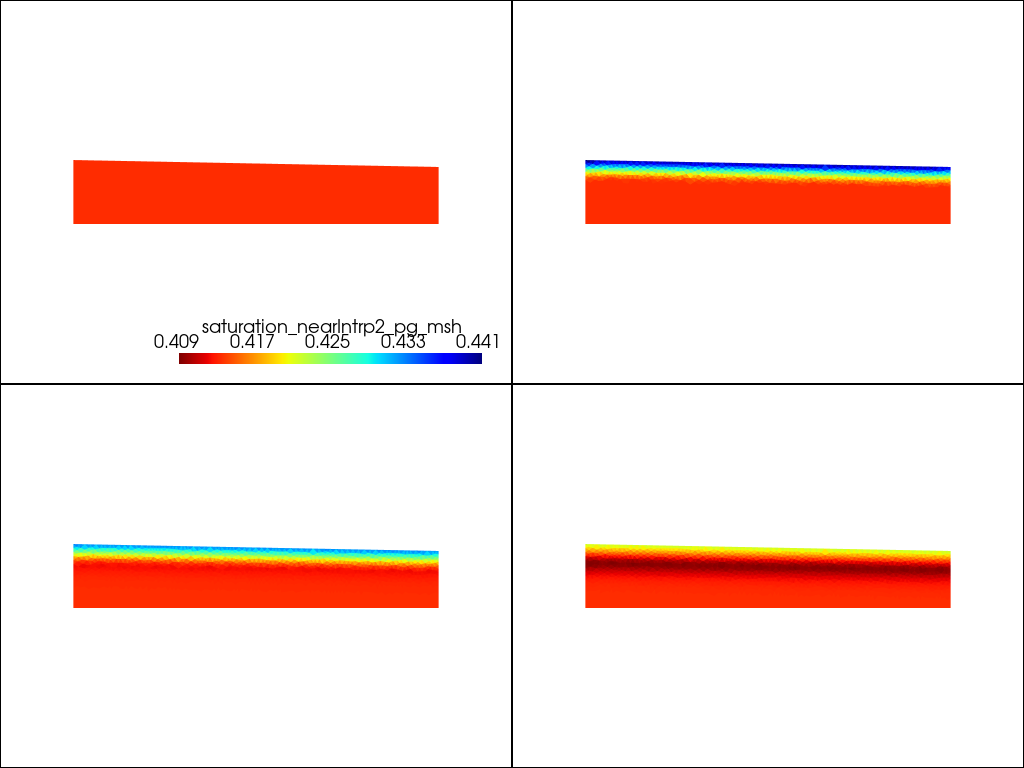

In [20]:
pl = pv.Plotter(shape=(2, 2))
axis_pl = [(0,0),(0,1),(1,0),(1,1)]
for i, j in enumerate([0,2,5,10]):
    mesh = pv.read(os.path.join(simu_solution.workdir,
                                'solution_ERTsaturation_nearIntrp2_pg_msh' + str(j) + '.vtk',
                                )
    
           )
    pl.subplot(axis_pl[i][0],axis_pl[i][1])
    pl.add_mesh(mesh,
               scalars='saturation_nearIntrp2_pg_msh',
                lighting=False,
                cmap="jet_r"
               )
    pl.view_xz()
pl.show()

## Going further with pygimli Time Lapse

In case we want to see the results in term of ER, we can invert the apparent resistivities. See: https://www.pygimli.org/_examples_auto/3_ert/plot_09_timelapse.html

```
for i in range(10):
    rhoa = pg.load('filenameRhoa_synthetic')
    DATA.append(rhoa)

tl = ert.TimelapseERT(DATA)
tl.invert(zWeight=0.3, lam=100)
tl.showAllModels();
```

## Reload DA results

In [21]:
simuWithDA = DA(
                        dirName='./DA_ERT',
                        prj_name= 'Weill_example_withDA',
                        notebook=True,
                    )
simuWithoutDA = DA(
                        dirName='./DA_ERT',
                        prj_name= 'Weill_example_withoutDA',
                        notebook=True,
                    )

🏁 Initiate CATHY object

🏁 Initiate CATHY object

In [22]:
results_withDA = simuWithDA.load_pickle_backup()
results_withoutDA = simuWithoutDA.load_pickle_backup()

In [23]:
observations = dictObs_2pd(results_withDA['dict_obs'])
#observations.xs('ERT',0).iloc[0]['elecs']

In [24]:
tobs= observations.index.get_level_values(1).to_list()

### ERT simulate

In [25]:
os.getcwd()

'/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks'

In [26]:
meshCiPG_PGref = pv.read('./solution_ERT/meshCi.vtk')
meshLiPG_PGref = pv.read('./solution_ERT/meshLi.vtk')
(meshCiPG, meshLiPG) = utils.define_mesh_transformations(meshCiPG_PGref,
                                                      meshLiPG_PGref,
                                                      idC=10, 
                                                      idL=10,
                                                    )

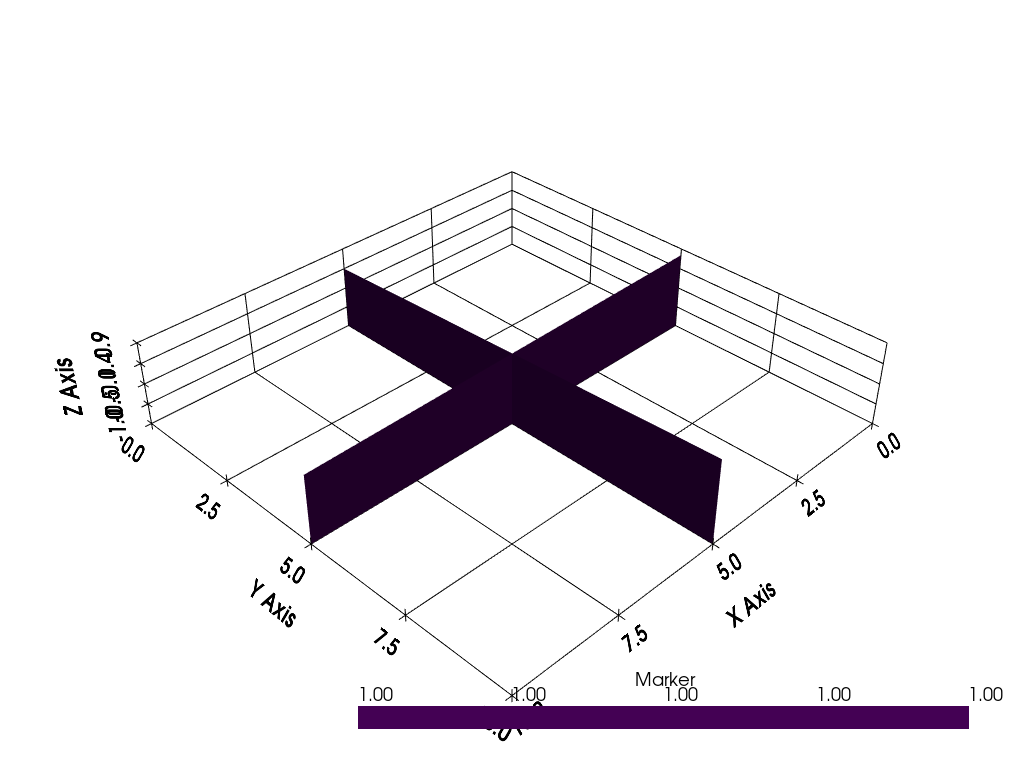

In [27]:
pl = pv.Plotter()
pl.add_mesh(meshCiPG)
pl.add_mesh(meshLiPG)
#pl.add_mesh(meshCATHY,opacity=0.5)
pl.show_grid()
pl.show()

In [28]:
ERT_meta_dict_meshLi={
                'forward_mesh_vtk_file': './solution_ERT/meshLi.vtk',
                'mesh_nodes_modif': meshLiPG.points
}

### Define Archie Parameters

In [39]:
sc = {}
rFluid_Archie = 1/(588*(1e-6/1e-2))
sc = {
    "POROS": [POROS_SOL],
    "rFluid_Archie": [rFluid_Archie],
    "a_Archie": [0.3],
    "m_Archie": [1.7],
    "n_Archie": [1.7],
    "pert_sigma_Archie": [0],
}

### Create ERT scheme

In [42]:
scheme = ert.createData(elecs=np.linspace(start=0, 
                                          stop=10, 
                                          num=21),
                           schemeName='dd')

In [52]:
meshLi = pg.load(ERT_meta_dict_meshLi['forward_mesh_vtk_file'])

In [56]:
%%capture

for i in range(len(tobs)):

    # read in CATHY mesh data
    # ------------------------------------------------------------------------
    path_CATHY = os.path.join(simuWithDA.workdir, 
                              simuWithDA.project_name , 
                              'DA_Ensemble/cathy_1/vtk/'
                              )
    if i<10:    
        filename = "10" + str(i) + ".vtk"
    elif i<100:
        filename = "1" + str(i) + ".vtk"
    
    meshCATHY = pv.read(path_CATHY+filename)
            
    meshLi_PG_withSaturation, scalar_new = cathy_meshtools.CATHY_2_pg(meshCATHY,
                                                                      ERT_meta_dict_meshLi,
                                                                      # show=True,
                                                                      )
    saturation = np.array(meshLi_PG_withSaturation[scalar_new])
    ER_converted_ti_noNoise = Archie.Archie_rho_DA(
                                                   sat = [saturation],
                                                   rFluid_Archie=sc['rFluid_Archie'], 
                                                   porosity=sc['POROS'], 
                                                   a_Archie=sc['a_Archie'], 
                                                   m_Archie=sc['m_Archie'], 
                                                   n_Archie=sc['n_Archie'],
                                                   pert_sigma_Archie=[0]
                                                   )
    rhomap = np.array(ER_converted_ti_noNoise)
    data = ert.simulate(meshLi, 
                        scheme=scheme, 
                        res=rhomap, 
                        noiseLevel=1,
                        noiseAbs=1e-6, 
                        seed=1337
                        )
    
    data.save('DA_ERT/ERTsimuWithDA/ERT_Li_' + str(i) + '.data')

16/05/24 - 11:44:11 - pyGIMLi - INFO - Data error estimate (min:max)  0.010001371286328416 : 0.02903313123568494


ModellingBase::setMesh() copying new mesh ... Found Neumann domain. Setting topography=1.
Found Neumann domain. but 2.5D -> neumann: false
Found datafile: 21 electrodes
Found: 21 free-electrodes
rMin = 0.25, rMax = 20
NGauLeg + NGauLag for inverse Fouriertransformation: 11 + 4
Found non-Neumann domain
0.00606531 s
FOP updating mesh dependencies ... 1.133e-06 s
Calculating response for model: min = 14.097 max = 14.097
Allocating memory for primary potential...... 0.000227234

No primary potential for secondary field calculation with topography.
Creating P2-Primmesh:		Nodes: 6429	Cells: 3114	Boundaries: 4771
ModellingBase::setMesh() copying new mesh ... Found Neumann domain. Setting topography=1.
Found Neumann domain. but 2.5D -> neumann: false
Found datafile: 21 electrodes
Found: 21 free-electrodes
rMin = 0.25, rMax = 20
NGauLeg + NGauLag for inverse Fouriertransformation: 11 + 4
Found non-Neumann domain
0.00595065 s
FOP updating mesh dependencies ... 1.578e-06 s
Forward: time: 0.434617

16/05/24 - 11:44:12 - pyGIMLi - INFO - Data error estimate (min:max)  0.010001371286328416 : 0.02903313123568494


ModellingBase::setMesh() copying new mesh ... Found Neumann domain. Setting topography=1.
Found Neumann domain. but 2.5D -> neumann: false
Found datafile: 21 electrodes
Found: 21 free-electrodes
rMin = 0.25, rMax = 20
NGauLeg + NGauLag for inverse Fouriertransformation: 11 + 4
Found non-Neumann domain
0.00589925 s
FOP updating mesh dependencies ... 1.158e-06 s
Calculating response for model: min = 14.097 max = 14.097
Allocating memory for primary potential...... 0.000214393

No primary potential for secondary field calculation with topography.
Creating P2-Primmesh:		Nodes: 6429	Cells: 3114	Boundaries: 4771
ModellingBase::setMesh() copying new mesh ... Found Neumann domain. Setting topography=1.
Found Neumann domain. but 2.5D -> neumann: false
Found datafile: 21 electrodes
Found: 21 free-electrodes
rMin = 0.25, rMax = 20
NGauLeg + NGauLag for inverse Fouriertransformation: 11 + 4
Found non-Neumann domain
0.0057813 s
FOP updating mesh dependencies ... 1.299e-06 s
Forward: time: 0.441817s

16/05/24 - 11:44:12 - pyGIMLi - INFO - Data error estimate (min:max)  0.010001371286328416 : 0.02903313123568494


ModellingBase::setMesh() copying new mesh ... Found Neumann domain. Setting topography=1.
Found Neumann domain. but 2.5D -> neumann: false
Found datafile: 21 electrodes
Found: 21 free-electrodes
rMin = 0.25, rMax = 20
NGauLeg + NGauLag for inverse Fouriertransformation: 11 + 4
Found non-Neumann domain
0.00611177 s
FOP updating mesh dependencies ... 1.129e-06 s
Calculating response for model: min = 14.097 max = 14.097
Allocating memory for primary potential...... 0.000217399

No primary potential for secondary field calculation with topography.
Creating P2-Primmesh:		Nodes: 6429	Cells: 3114	Boundaries: 4771
ModellingBase::setMesh() copying new mesh ... Found Neumann domain. Setting topography=1.
Found Neumann domain. but 2.5D -> neumann: false
Found datafile: 21 electrodes
Found: 21 free-electrodes
rMin = 0.25, rMax = 20
NGauLeg + NGauLag for inverse Fouriertransformation: 11 + 4
Found non-Neumann domain
0.00589302 s
FOP updating mesh dependencies ... 1.213e-06 s
Forward: time: 0.434312

16/05/24 - 11:44:13 - pyGIMLi - INFO - Data error estimate (min:max)  0.010001371286328416 : 0.02903313123568494


FileNotFoundError: File (/home/z0272571a@CAMPUS.CSIC.ES/Nextcloud/BenCSIC/Codes/BenjMy/ETH_pyCATHY/notebooks/DA_ERT/Weill_example_withDA/DA_Ensemble/cathy_1/vtk/104.vtk) not found

Found datafile: 21 electrodes
Found: 21 free-electrodes
rMin = 0.25, rMax = 20
NGauLeg + NGauLag for inverse Fouriertransformation: 11 + 4
Found non-Neumann domain
0.00596655 s
FOP updating mesh dependencies ... 1.181e-06 s
Calculating response for model: min = 14.097 max = 14.097
Allocating memory for primary potential...... 0.00021654

No primary potential for secondary field calculation with topography.
Creating P2-Primmesh:		Nodes: 6429	Cells: 3114	Boundaries: 4771
ModellingBase::setMesh() copying new mesh ... Found Neumann domain. Setting topography=1.
Found Neumann domain. but 2.5D -> neumann: false
Found datafile: 21 electrodes
Found: 21 free-electrodes
rMin = 0.25, rMax = 20
NGauLeg + NGauLag for inverse Fouriertransformation: 11 + 4
Found non-Neumann domain
0.0057804 s
FOP updating mesh dependencies ... 1.28e-06 s
Forward: time: 0.441719s
Interpolating to secondary mesh

315 	/ 315
Forward: time: 0.622311s
Response: min = 0.56694 max = 13.0916 mean = 7.7841
Reciprocity rms(mod

### Archie

In [31]:
results_withDA.keys()

dict_keys(['meta_DA', 'dict_parm_pert', 'df_DA', 'dict_obs', 'df_performance', 'df_Archie'])

In [32]:
Archie = results_withDA['df_Archie']
Archie_ER = Archie.set_index(['time','ens_nbi'])
Archie_ER

ens_nb        sw  ER_converted   OL  porosity
time ens_nbi                                              
0.0  0.0        NaN  0.672994     27.638137  0.0      0.55
     0.0        NaN  0.672602     27.665519  0.0      0.55
     0.0        NaN  0.672672     27.660611  0.0      0.55
     0.0        NaN  0.672713     27.657710  0.0      0.55
     0.0        NaN  0.672787     27.652588  0.0      0.55
...             ...       ...           ...  ...       ...
9.0  31.0       NaN  0.272770    128.313890  0.0      0.55
     31.0       NaN  0.272770    128.313970  0.0      0.55
     31.0       NaN  0.272770    128.313970  0.0      0.55
     31.0       NaN  0.272770    128.313970  0.0      0.55
     31.0       NaN  0.272769    128.314130  0.0      0.55

[1439424 rows x 5 columns]

In [33]:
Archie.time.unique()

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [34]:
meanArchie = Archie.groupby('time')['ER_converted'].mean()
minArchie = Archie.groupby('time')['ER_converted'].min()
maxArchie = Archie.groupby('time')['ER_converted'].max()
minArchie

time
0.0     14.097021
1.0     14.097021
2.0    126.355881
3.0    126.355725
4.0    126.355569
5.0    126.355491
6.0    126.355335
7.0    126.355178
8.0    126.355100
9.0    126.355100
Name: ER_converted, dtype: float64

Text(0, 0.5, 'ER converted')

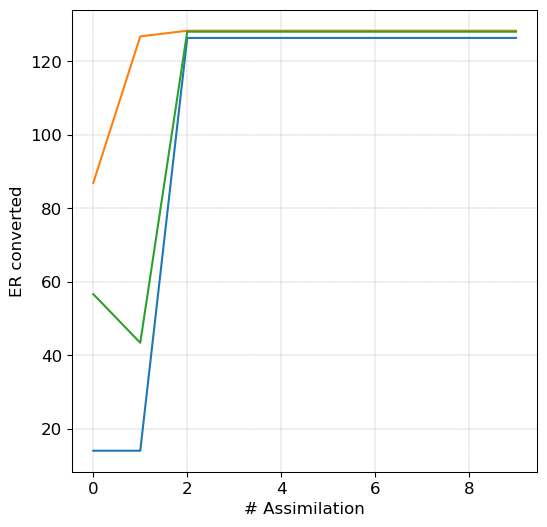

In [35]:
fig, ax = plt.subplots()
minArchie.plot(ax=ax)
maxArchie.plot(ax=ax)
meanArchie.plot(ax=ax)
ax.set_xlabel('# Assimilation')
ax.set_ylabel('ER converted')


## Plot 1:1 line between observed ER and estimated ER

In [52]:
Archie['ER_converted']

0        33.105120
1        32.946608
2        32.928546
3        32.919079
4        32.910675
           ...    
7051    128.313570
7052    128.313570
7053    128.313570
7054    128.313650
7055    128.313730
Name: ER_converted, Length: 1305360, dtype: float64

In [28]:
metadata_ERT    = {
                    'data_type': '$ERT$', # units
                    'units': '$\Ohm$', # units transfer_resistances
                    'forward_mesh_vtk_file': '../solution_ERT/meshLi.vtk', # path to the ERT mesh (vtk file compatible with pygimli or resipy)
                    # 'sequenceERT': sequenceERT, # path to the ERT sequence  (file compatible with pygimli or resipy)
                    # 'instrument': 'Syscal', # Instrument
                    'data_format': 'pygimli', # format (raw or preprocessed)
                    'dataErr': 0.5, # error in %
                    'fwdNoiseLevel': 5, # error in %
                    #'mesh_nodes_modif': meshLiPG.points, 
        
                }

In [30]:
dict_obs = {}
for i, tt in enumerate(Archie.time.unique()):

    if i == 0:
        continue
    
    # .data file observation generated by pygimli
    filename = os.path.join(simu_solution.workdir,
                            'ERTsolution', 
                            'ERT_Li_' + str(i) + '.data'
                            )    
    data_measure = read_observations(
                                    dict_obs,
                                    filename, 
                                    data_type = 'ERT', 
                                    data_err = 0.5,
                                    show=True,
                                    tA=tt,
                                    obs_cov_type='data_err', #data_err
                                    meta=metadata_ERT,
                                    ) 
data_measure_df = dictObs_2pd(dict_obs) 

In [54]:
meanArchie

time
0.0     59.851983
1.0     44.881976
2.0    125.011068
3.0    125.011010
4.0    125.010950
5.0    125.010891
6.0    125.010831
7.0    125.010772
8.0    125.010772
Name: ER_converted, dtype: float64

In [105]:
data_rhoa = data_measure_df.xs('ERT')['data']
data_rhoa.iloc[0].head()

,a,b,m,n,k,r,rhoa,err,valid
0,0,1,2,3,-9.424778,0.0,21.346229,0.01,1.0
1,1,2,3,4,-9.424778,0.0,27.008036,0.01,1.0
2,2,3,4,5,-9.424778,0.0,28.710987,0.01,1.0
3,3,4,5,6,-9.424778,0.0,28.894254,0.01,1.0
4,4,5,6,7,-9.424778,0.0,29.136685,0.01,1.0


ValueError: x and y must be the same size

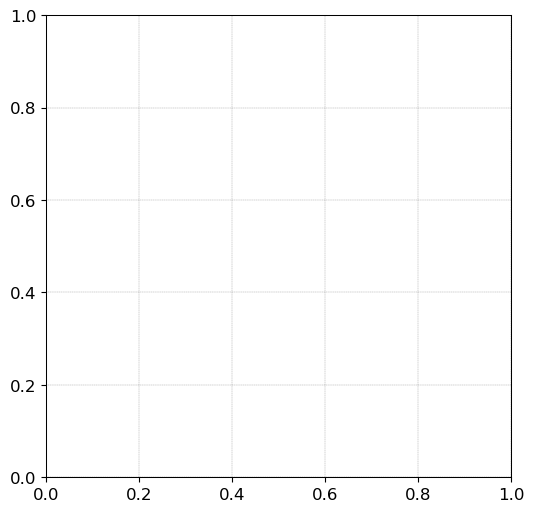

In [83]:
fig, ax = plt.subplots() 
ax.scatter(data_rhoa.iloc[0]['rhoa'].values,
           Archie.groupby('ens_nbi')['ER_converted'].mean().values
          )
           